<a href="https://colab.research.google.com/github/benjamingonzalez10-afk/PortafolioCDDPEc/blob/Etapa_3/Examen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Uso de la api del banco mundial

La versión 1.0.4 del  paquete wbgapi de Python  ya está disponible. Este paquete lleva casi un año en el  Índice de Paquetes de Python  y la última versión incorpora varias funciones nuevas para que la exploración y la búsqueda en bases de datos sean más sencillas e interactivas.

# **Etapa 1: Análisis Descriptivo e Imputación de Datos**

**Revisión general del dataset**

- Identificar el número de países, años y variables disponibles.

- Número total de observaciones

- Porcentaje de datos faltantes por variable: En caso que la variable cuente con menos de un 15% de datos NA se recomienda imputar. En caso contrario, eliminar variable.

- Identificación de outliers relevantes

- Otras observaciones relevantes.


**Indicaciones**:

- Generar una tabla de estadísticas descriptivas: media, mediana, desviación estándar, máximo, mínimo.

- Mostrar la distribución del PIB (histograma o boxplot), ya que es la variable objetivo.

- Mapa con la distribución del PIB

- Discretizar la variable dependiente `NY.GDP.MKTP.PP.KD` de aceurdo con la siguiente indicación.

    ```python
    df_wb_raw['NY.GDP.MKTP.PP.KD'] = pd.qcut(df_wb_raw['NY.GDP.MKTP.PP.KD'], q=5, labels=['Low', 'Medium-Low', 'Medium', 'Medium-High', 'High'])

    ```

- Enviar a Github a la rama 1 el notebook ejecutado en esta etapa.

    **Nota**: Debe describir de manera clara y ordenada los pasos realizados durante el desarrollo del proyecto, incorporando una breve justificación para cada uno de ellos, de modo que se expliciten las decisiones adoptadas y su coherencia con los objetivos planteados.

    Esta indicación es válida para todas las etapas del proyecto.

## **Introducción**
Este proyecto tiene como objetivo predecir el nivel de Producto Interno Bruto (PIB) de distintos países utilizando un conjunto de indicadores económicos, sociales y demográficos obtenidos desde las bases de datos del Banco Mundial. Para ello, se emplea el paquete wbgapi en Python, el cual permite acceder de manera programática tanto a los datos como a sus metadatos mediante la API oficial del Banco Mundial, facilitando la descarga, exploración y selección de series e indicadores relevantes.

En particular, se considera la versión 1.0. de wbgapi, la cual incorporó mejoras orientadas a hacer la búsqueda y exploración de bases de datos más simple e interactiva, lo que resulta útil para estructurar un flujo de trabajo reproducible: desde la obtención y limpieza de datos en Google Colab, hasta la documentación y publicación del proyecto en GitHub.

In [211]:
#Instalar biblioteca
%pip install wbgapi
%pip install fancyimpute

In [212]:
import wbgapi as wb
from google.colab import drive
from datetime import datetime
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive')

import my_func as fn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import statsmodels.api as sm
from scipy.stats import chi2
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                             precision_score, recall_score, f1_score, ConfusionMatrixDisplay,
                             cohen_kappa_score, roc_auc_score)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
warnings.filterwarnings("ignore")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importaremos información del banco mundial

In [213]:
import my_func as fn

In [214]:
# Indicadores a consultar
indicadores_wb = {
    "NY.GDP.MKTP.PP.KD": "GDP, PPP (constant 2021 international $)",
    "SP.POP.GROW": "Population growth (annual %)",
    "SP.POP.TOTL": "Population, total",
    "SP.POP.TOTL.FE.IN": "Population, female",
    "SP.POP.TOTL.FE.ZS": "Population, female (% of total population)",
    "SP.POP.TOTL.MA.IN": "Population, male",
    "SP.POP.TOTL.MA.ZS": "Population, male (% of total population)",
    "SP.URB.GROW": "Urban population growth (annual %)",
    "SP.URB.TOTL": "Urban population",
    "SP.URB.TOTL.IN.ZS": "Urban population (% of total population)",
    "SP.RUR.TOTL": "Rural population",
    "SP.RUR.TOTL.ZG": "Rural population growth (annual %)",
    "SP.RUR.TOTL.ZS": "Rural population (% of total population)",
    "SL.TLF.TOTL.IN": "Labor force, total",
    "SL.TLF.TOTL.FE.ZS": "Labor force, female (% of total labor force)",
    "SL.UEM.TOTL.FE.NE.ZS": "Unemployment, female (% of female labor force) (national estimate)",
    "SL.UEM.TOTL.FE.ZS": "Unemployment, female (% of female labor force) (modeled ILO estimate)",
    "SL.UEM.TOTL.MA.NE.ZS": "Unemployment, male (% of male labor force) (national estimate)",
    "SL.UEM.TOTL.MA.ZS": "Unemployment, male (% of male labor force) (modeled ILO estimate)",
    "SL.UEM.TOTL.NE.ZS": "Unemployment, total (% of total labor force) (national estimate)",
    "SL.UEM.TOTL.ZS": "Unemployment, total (% of total labor force) (modeled ILO estimate)",
    "FP.CPI.TOTL.ZG": "Inflation, consumer prices (annual %)",
    "GC.TAX.EXPT.CN": "Taxes on exports (current LCU)",
    "GC.TAX.EXPT.ZS": "Taxes on exports (% of tax revenue)",
    "NE.EXP.GNFS.KD.ZG": "Exports of goods and services (annual % growth)",
    "NE.EXP.GNFS.KN": "Exports of goods and services (constant LCU)",
    "NE.EXP.GNFS.ZS": "Exports of goods and services (% of GDP)",
    "NV.AGR.TOTL.CD": "Agriculture, forestry, and fishing, value added (current US$)",
    "NV.AGR.TOTL.CN": "Agriculture, forestry, and fishing, value added (current LCU)",
    "NV.IND.MANF.CD": "Manufacturing, value added (current US$)",
    "NV.IND.MANF.CN": "Manufacturing, value added (current LCU)",
    "NV.IND.TOTL.CD": "Industry (including construction), value added (current US$)",
    "NV.IND.TOTL.CN": "Industry (including construction), value added (current LCU)",
    "NV.SRV.TOTL.CD": "Services, value added (current US$)",
    "NV.SRV.TOTL.CN": "Services, value added (current LCU)",
    "GE.EST": "Government Effectiveness: Estimate",
    "NE.CON.GOVT.KN": "General government final consumption expenditure (constant LCU)",
    "NE.CON.GOVT.ZS": "General government final consumption expenditure (% of GDP)",
    "NE.CON.PRVT.CD": "Households and NPISHs Final consumption expenditure (current US$)",
    "NE.CON.PRVT.CN": "Households and NPISHs Final consumption expenditure (current LCU)",
    "GC.DOD.TOTL.CN": "Central government debt, total (current LCU)",
    "GC.DOD.TOTL.GD.ZS": "Central government debt, total (% of GDP)",
    "BM.KLT.DINV.CD.WD": "Foreign direct investment, net outflows (BoP, current US$)",
    "BX.KLT.DINV.WD.GD.ZS": "Foreign direct investment, net inflows (% of GDP)",
    "EG.ELC.LOSS.ZS": "Electric power transmission and distribution losses (% of output)",
    "EG.USE.ELEC.KH.PC": "Electric power consumption (kWh per capita)",
    "EN.GHG.CO2.IP.MT.CE.AR5": "Carbon dioxide emissions from Industrial Processes (Mt CO2e)",
    "SE.PRM.NENR": "School enrollment, primary (% net)",
    "SE.PRM.NENR.FE": "School enrollment, primary, female (% net)",
    "SE.PRM.NENR.MA": "School enrollment, primary, male (% net)",
    "SE.SEC.ENRR": "School enrollment, secondary (% gross)",
    "SE.SEC.ENRR.FE": "School enrollment, secondary, female (% gross)",
    "SE.SEC.ENRR.MA": "School enrollment, secondary, male (% gross)",
    "SE.TER.ENRR": "School enrollment, tertiary (% gross)",
    "SE.TER.ENRR.FE": "School enrollment, tertiary, female (% gross)",
    "SE.TER.ENRR.MA": "School enrollment, tertiary, male (% gross)",
    "SP.DYN.LE00.IN": "Life expectancy at birth, total (years)",
    "SP.DYN.LE00.FE.IN": "Life expectancy at birth, female (years)",
    "SP.DYN.LE00.MA.IN": "Life expectancy at birth, male (years)",
    "EG.CFT.ACCS.ZS": "Access to clean fuels and technologies for cooking (% of population)",
    "EG.CFT.ACCS.RU.ZS": "Access to clean fuels and technologies for cooking, rural (% of rural population)",
    "EG.CFT.ACCS.UR.ZS": "Access to clean fuels and technologies for cooking, urban (% of urban population)",
    "IT.NET.USER.FE.ZS": "Individuals using the Internet, female (% of female population)",
    "IT.NET.USER.MA.ZS": "Individuals using the Internet, male (% of male population)",
    "IT.NET.USER.ZS": "Individuals using the Internet (% of population)",
}


In [215]:
# Descarga de datos
df_wb_raw = fn.descargar_en_chunks(indicadores_wb, años=2023, chunk_size=10)

Descargando bloque 1: ['NY.GDP.MKTP.PP.KD', 'SP.POP.GROW', 'SP.POP.TOTL', 'SP.POP.TOTL.FE.IN', 'SP.POP.TOTL.FE.ZS', 'SP.POP.TOTL.MA.IN', 'SP.POP.TOTL.MA.ZS', 'SP.URB.GROW', 'SP.URB.TOTL', 'SP.URB.TOTL.IN.ZS']
Descargando bloque 2: ['SP.RUR.TOTL', 'SP.RUR.TOTL.ZG', 'SP.RUR.TOTL.ZS', 'SL.TLF.TOTL.IN', 'SL.TLF.TOTL.FE.ZS', 'SL.UEM.TOTL.FE.NE.ZS', 'SL.UEM.TOTL.FE.ZS', 'SL.UEM.TOTL.MA.NE.ZS', 'SL.UEM.TOTL.MA.ZS', 'SL.UEM.TOTL.NE.ZS']
Descargando bloque 3: ['SL.UEM.TOTL.ZS', 'FP.CPI.TOTL.ZG', 'GC.TAX.EXPT.CN', 'GC.TAX.EXPT.ZS', 'NE.EXP.GNFS.KD.ZG', 'NE.EXP.GNFS.KN', 'NE.EXP.GNFS.ZS', 'NV.AGR.TOTL.CD', 'NV.AGR.TOTL.CN', 'NV.IND.MANF.CD']
Descargando bloque 4: ['NV.IND.MANF.CN', 'NV.IND.TOTL.CD', 'NV.IND.TOTL.CN', 'NV.SRV.TOTL.CD', 'NV.SRV.TOTL.CN', 'GE.EST', 'NE.CON.GOVT.KN', 'NE.CON.GOVT.ZS', 'NE.CON.PRVT.CD', 'NE.CON.PRVT.CN']
Descargando bloque 5: ['GC.DOD.TOTL.CN', 'GC.DOD.TOTL.GD.ZS', 'BM.KLT.DINV.CD.WD', 'BX.KLT.DINV.WD.GD.ZS', 'EG.ELC.LOSS.ZS', 'EG.USE.ELEC.KH.PC', 'EN.GHG.CO2.IP.MT.CE

In [216]:
# Seleccionar solamente paises usando código ISO
table_dict = vars(wb.economy.info())
df_paises = pd.DataFrame(table_dict.get('items'))
iso_list = list(df_paises[df_paises['aggregate'] == False]['id'])

In [217]:
#Seleccionar solamente paises con ISO.
df_wb_raw = df_wb_raw[df_wb_raw['country'].isin(iso_list)].reset_index(drop = True)

In [218]:
df_wb_raw.head()

,country,Country,NY.GDP.MKTP.PP.KD,SP.POP.GROW,SP.POP.TOTL,SP.POP.TOTL.FE.IN,SP.POP.TOTL.FE.ZS,SP.POP.TOTL.MA.IN,SP.POP.TOTL.MA.ZS,SP.URB.GROW,...,SE.TER.ENRR.FE,SE.TER.ENRR.MA,SP.DYN.LE00.FE.IN,SP.DYN.LE00.IN,SP.DYN.LE00.MA.IN,EG.CFT.ACCS.RU.ZS,EG.CFT.ACCS.UR.ZS,IT.NET.USER.FE.ZS,IT.NET.USER.MA.ZS,IT.NET.USER.ZS
0,ZWE,Zimbabwe,8.526678e+10,1.677096,16340822.0,8559888.0,52.383460,7780934.0,47.616540,3.180794,...,NaN,NaN,65.013,62.775,60.226,7.5,77.0,NaN,NaN,38.4266
1,ZMB,Zambia,7.612916e+10,2.794068,20723965.0,10467717.0,50.510204,10256248.0,49.489796,3.753005,...,NaN,NaN,68.673,66.349,63.936,2.3,16.8,NaN,NaN,33.0000
2,PSE,West Bank and Gaza,2.769440e+10,2.393265,5165775.0,2598445.0,50.301172,2567330.0,49.698828,2.694855,...,54.781748,33.968858,71.502,65.170,59.691,NaN,NaN,86.2802,86.9849,86.6377
3,VNM,Viet Nam,1.359364e+12,0.671429,100352192.0,51201223.0,51.021529,49150969.0,48.978471,2.209665,...,36.077468,29.637136,79.264,74.588,69.877,98.7,99.4,75.8894,80.3200,78.0800
4,VUT,Vanuatu,1.030020e+09,2.324816,320409.0,158611.0,49.502667,161798.0,50.497333,2.374479,...,NaN,NaN,73.927,71.477,69.445,9.0,52.3,NaN,NaN,45.7313


### Limpieza de la base de datos


#### Eliminar variables con muchos datos faltantes
Criterio:
- Si "NaN" >= 10%, se elimina la variable
- Si "NaN" < 10%, se conserva la variable

In [219]:
(df_wb_raw.isna().sum() / len(df_wb_raw)>= 0.1).sum()

np.int64(36)

In [220]:
lista = []
for i in df_wb_raw.columns:
  if df_wb_raw[i].isna().sum()/ len(df_wb_raw)>= 0.1:
    df_wb_raw.drop(i, axis = 1, inplace = True)
    lista.append(i)
print(f'Se eliminaron {len(lista)} columnas')

Se eliminaron 36 columnas


In [221]:
(df_wb_raw.isna().sum() / len(df_wb_raw)> 0).sum()

np.int64(14)

In [222]:
print(f"Todavía quedan {(df_wb_raw.isna().sum() / len(df_wb_raw)> 0).sum()} columnas con datos nulos")

Todavía quedan 14 columnas con datos nulos


#### Imputación de datos

Se utilizarán dos modelos, uno paramétrico y uno no paramétrico, luego se compararán ambos y se utilizará el más preciso.

In [223]:
#crear una lista con las columnas con datos faltantes
df_faltante = []
for i in df_wb_raw.columns:
  if df_wb_raw[i].isna().sum()/ len(df_wb_raw)> 0 :
    df_faltante.append(i)
print(f"Columnas con datos faltantes: {df_faltante}")

Columnas con datos faltantes: ['SP.RUR.TOTL.ZG', 'NV.AGR.TOTL.CD', 'NV.AGR.TOTL.CN', 'GE.EST', 'NV.IND.TOTL.CD', 'NV.IND.TOTL.CN', 'NV.SRV.TOTL.CD', 'NV.SRV.TOTL.CN', 'BM.KLT.DINV.CD.WD', 'BX.KLT.DINV.WD.GD.ZS', 'EN.GHG.CO2.IP.MT.CE.AR5', 'EG.CFT.ACCS.ZS', 'EG.CFT.ACCS.RU.ZS', 'EG.CFT.ACCS.UR.ZS']


##### Imputación Paramétrica (media)

In [224]:
dfmedia = df_wb_raw.copy()
dfmedia = dfmedia.drop(columns = ['country','Country'])
from sklearn.impute import SimpleImputer
simple = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = simple.fit_transform(dfmedia)
dfmedia = pd.DataFrame(imputer, columns = dfmedia.columns)


##### Imputación No paramétrica (FancyImpute)

In [225]:
from fancyimpute import IterativeImputer
df = df_wb_raw.copy()
# Inicializar imputador IterativeImputer
mice_imputer = IterativeImputer()

# Ajustar y transformar
imputed_mice = mice_imputer.fit_transform(df[df_faltante])

# Guardar como DataFrame
df_imputed_mice = pd.DataFrame(imputed_mice, columns=df[df_faltante].columns)

##### Comparación de los modelos

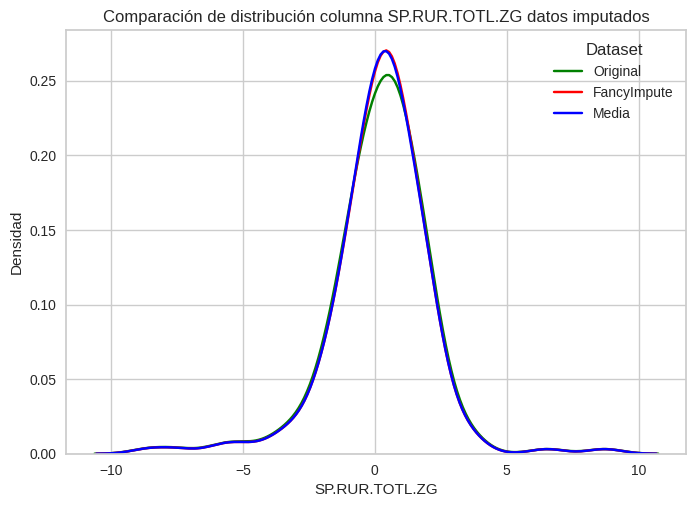

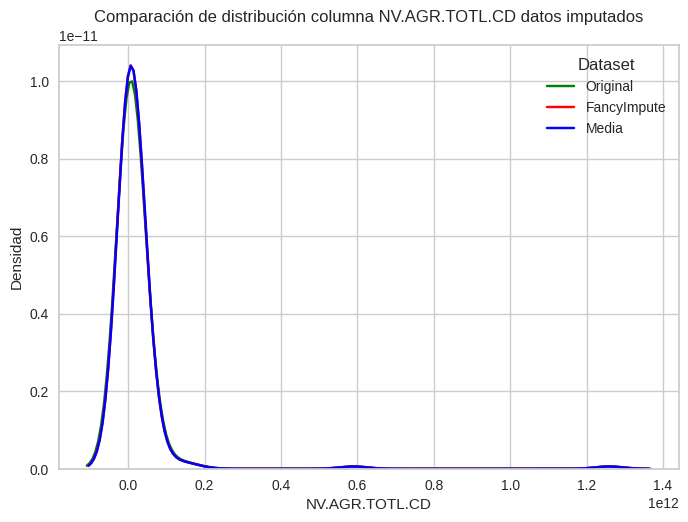

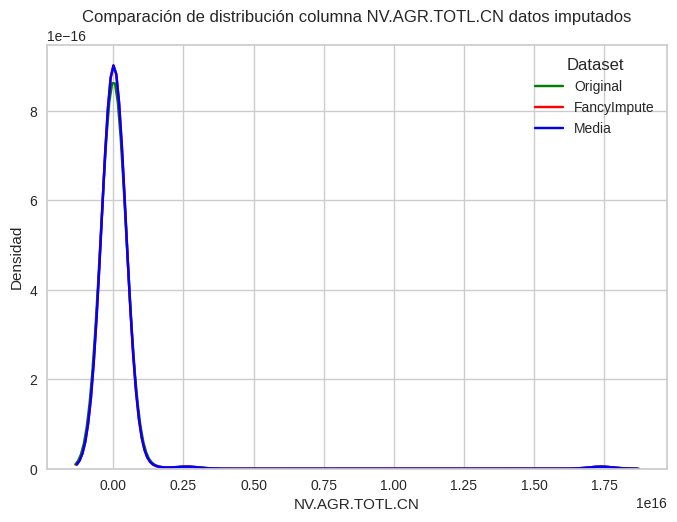

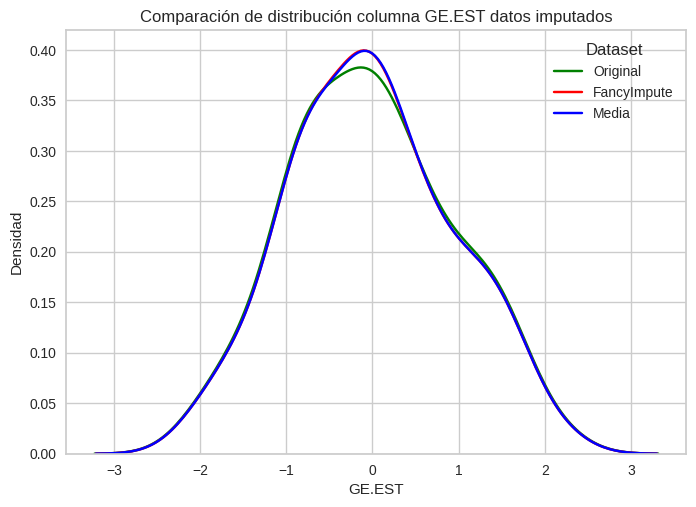

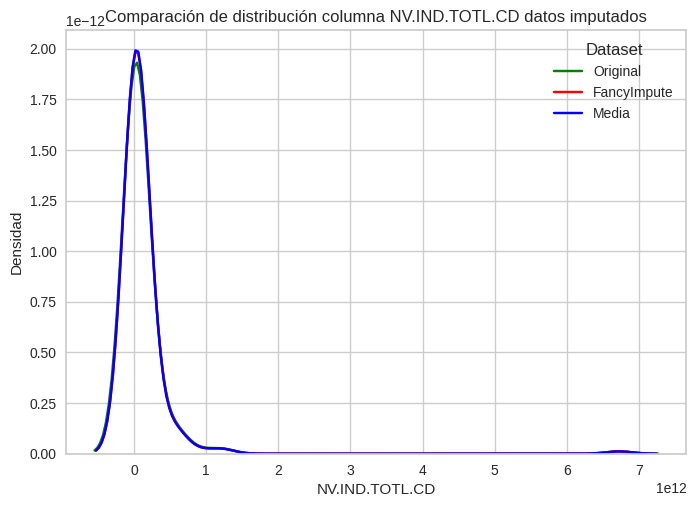

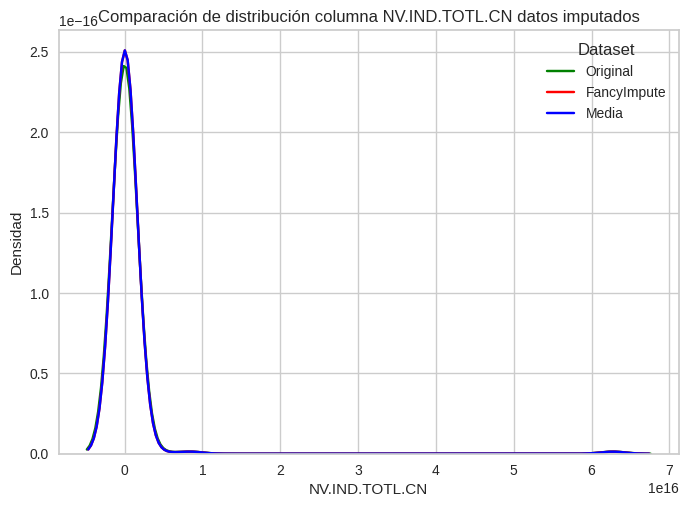

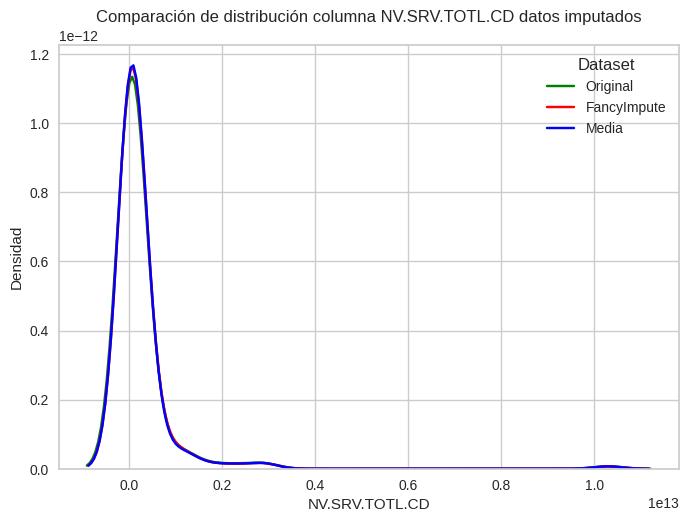

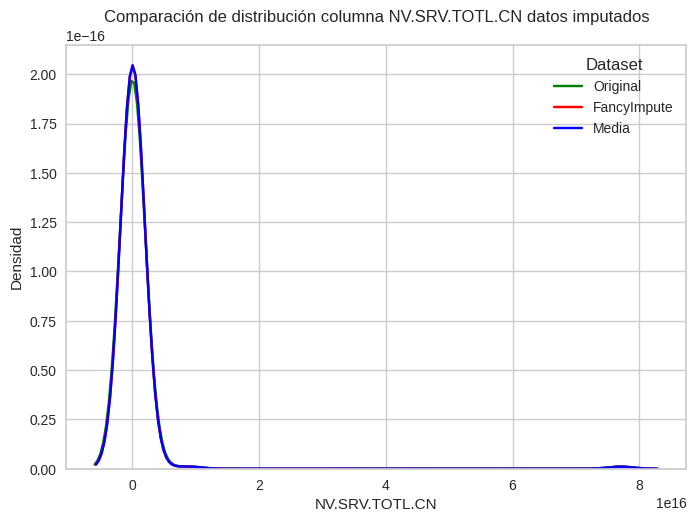

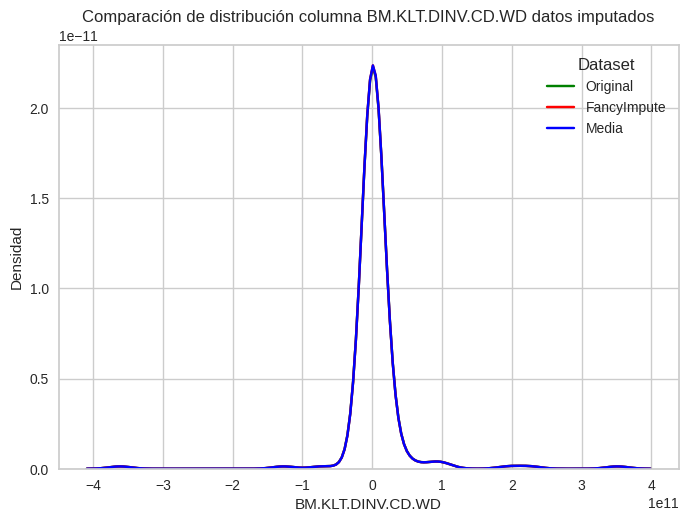

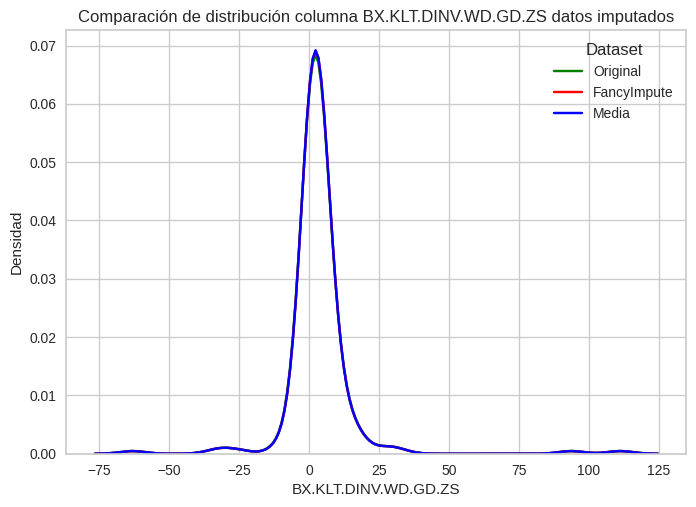

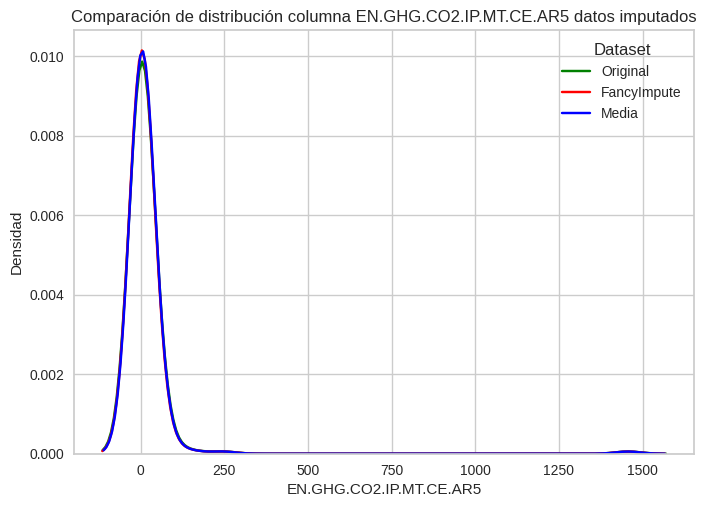

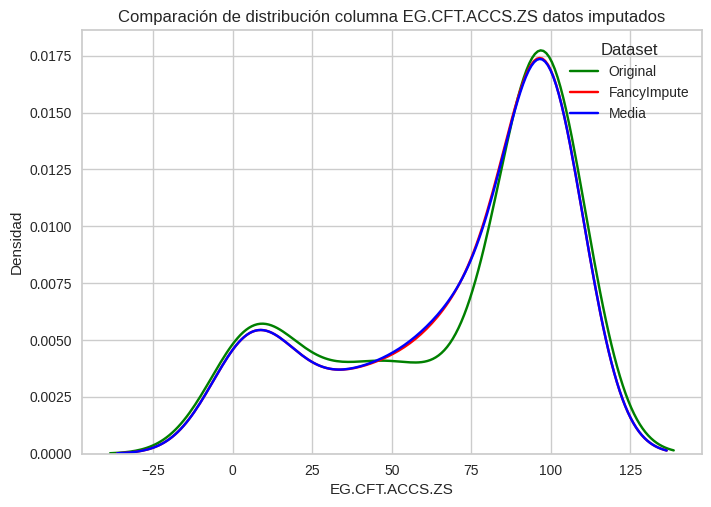

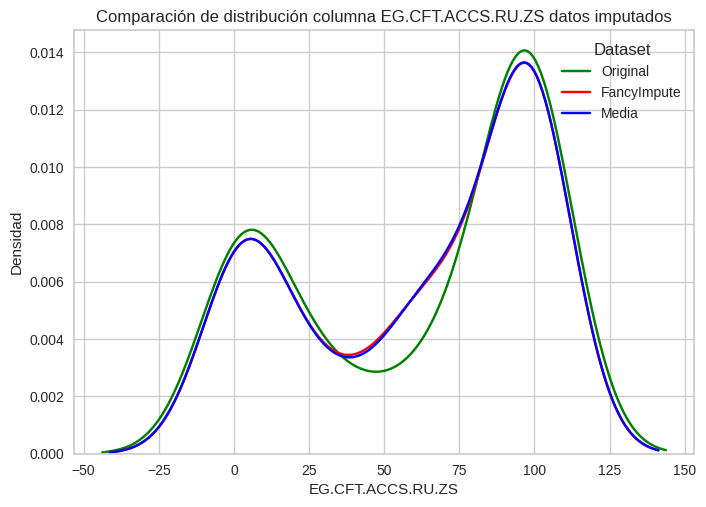

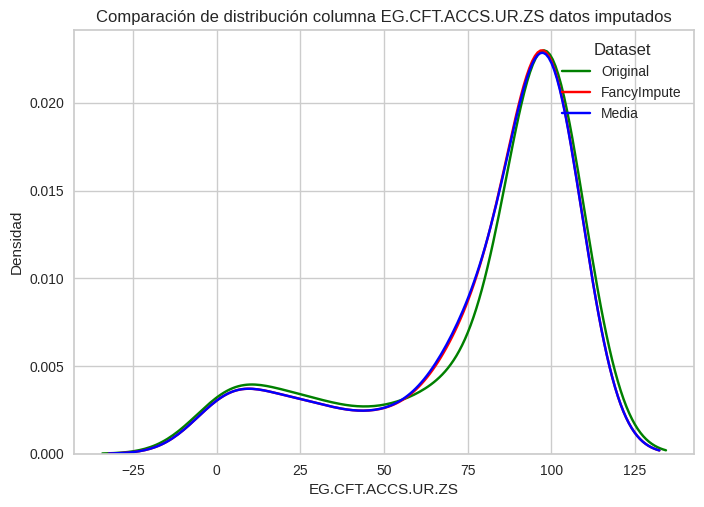

In [226]:
columnas = df[df_faltante].columns

for col in columnas:

  # Gráfico KDE comparando dos datasets
  sns.kdeplot(data=df_wb_raw, x= col, label='Original', color='green')
  sns.kdeplot(data=df_imputed_mice, x=col, label='FancyImpute', color='red')
  sns.kdeplot(data=dfmedia, x=col, label='Media', color='blue')

  # Agregar leyenda
  plt.legend(title='Dataset', loc='upper right')


  # Personalizar el gráfico
  plt.title(f"Comparación de distribución columna {col} datos imputados")
  plt.xlabel(col)
  plt.ylabel("Densidad")

  plt.show()

Ambos métodos son bastante parecidos, por lo que no habrá gran diferencia entre escoger uno o el otro. Nos quedamos con FancyImpute

In [227]:
df[df_faltante] = df_imputed_mice # Se agregan los datos nuevos a la base original

### Análisis descriptivo


In [228]:
df

,country,Country,NY.GDP.MKTP.PP.KD,SP.POP.GROW,SP.POP.TOTL,SP.POP.TOTL.FE.IN,SP.POP.TOTL.FE.ZS,SP.POP.TOTL.MA.IN,SP.POP.TOTL.MA.ZS,SP.URB.GROW,...,NV.SRV.TOTL.CN,BM.KLT.DINV.CD.WD,BX.KLT.DINV.WD.GD.ZS,EN.GHG.CO2.IP.MT.CE.AR5,EG.CFT.ACCS.ZS,SP.DYN.LE00.FE.IN,SP.DYN.LE00.IN,SP.DYN.LE00.MA.IN,EG.CFT.ACCS.RU.ZS,EG.CFT.ACCS.UR.ZS
0,ZWE,Zimbabwe,8.526678e+10,1.677096,16340822.0,8559888.0,52.383460,7780934.0,47.616540,3.180794,...,3.348446e+10,3.050000e+07,1.684321,0.963600,30.700000,65.013,62.775,60.226,7.500000,77.000000
1,ZMB,Zambia,7.612916e+10,2.794068,20723965.0,10467717.0,50.510204,10256248.0,49.489796,3.753005,...,3.167001e+11,1.532150e+08,2.324653,1.290500,9.200000,68.673,66.349,63.936,2.300000,16.800000
2,PSE,West Bank and Gaza,2.769440e+10,2.393265,5165775.0,2598445.0,50.301172,2567330.0,49.698828,2.694855,...,1.044720e+10,3.159065e+06,0.580098,-3.507426,69.968564,71.502,65.170,59.691,60.865185,78.950134
3,VNM,Viet Nam,1.359364e+12,0.671429,100352192.0,51201223.0,51.021529,49150969.0,48.978471,2.209665,...,4.364896e+15,-1.550000e+09,4.264071,50.189800,98.700000,79.264,74.588,69.877,98.700000,99.400000
4,VUT,Vanuatu,1.030020e+09,2.324816,320409.0,158611.0,49.502667,161798.0,50.497333,2.374479,...,5.135585e+14,4.399200e+06,0.830619,0.001100,20.600000,73.927,71.477,69.445,9.000000,52.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,AGO,Angola,3.229678e+11,3.080655,36749906.0,18568216.0,50.525887,18181690.0,49.474113,4.233833,...,3.274279e+13,3.335616e+07,-1.977864,1.797700,50.200000,67.144,64.617,62.099,8.400000,75.000000
194,AND,Andorra,5.225828e+09,1.433748,80856.0,39502.0,48.854754,41354.0,51.145246,1.506784,...,2.741340e+09,2.215940e+08,7.285975,-3.795838,100.000000,86.107,84.041,82.100,100.000000,100.000000
195,DZA,Algeria,6.998184e+11,1.498976,46164219.0,22614984.0,48.988123,23549235.0,51.011877,2.241995,...,1.533987e+13,1.655830e+08,0.489819,16.388400,99.700000,77.696,76.261,74.895,99.100000,99.900000
196,ALB,Albania,4.944312e+10,-1.543108,2414095.0,1220548.0,50.559226,1193547.0,49.440774,-0.946506,...,1.126932e+12,2.627767e+08,6.900370,0.818600,86.100000,81.446,79.602,77.728,72.500000,95.200000


In [229]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   country                  198 non-null    object 
 1   Country                  198 non-null    object 
 2   NY.GDP.MKTP.PP.KD        198 non-null    float64
 3   SP.POP.GROW              198 non-null    float64
 4   SP.POP.TOTL              198 non-null    float64
 5   SP.POP.TOTL.FE.IN        198 non-null    float64
 6   SP.POP.TOTL.FE.ZS        198 non-null    float64
 7   SP.POP.TOTL.MA.IN        198 non-null    float64
 8   SP.POP.TOTL.MA.ZS        198 non-null    float64
 9   SP.URB.GROW              198 non-null    float64
 10  SP.URB.TOTL              198 non-null    float64
 11  SP.URB.TOTL.IN.ZS        198 non-null    float64
 12  SP.RUR.TOTL              198 non-null    float64
 13  SP.RUR.TOTL.ZG           198 non-null    float64
 14  SP.RUR.TOTL.ZS           1

In [230]:
print(f"El dataset tiene {df.shape[0]} países, {df.shape[1]-2} variables y {df.shape[0]*(df.shape[1]-2)} observaciones")

El dataset tiene 198 países, 29 variables y 5742 observaciones


In [231]:
df.describe()

,NY.GDP.MKTP.PP.KD,SP.POP.GROW,SP.POP.TOTL,SP.POP.TOTL.FE.IN,SP.POP.TOTL.FE.ZS,SP.POP.TOTL.MA.IN,SP.POP.TOTL.MA.ZS,SP.URB.GROW,SP.URB.TOTL,SP.URB.TOTL.IN.ZS,...,NV.SRV.TOTL.CN,BM.KLT.DINV.CD.WD,BX.KLT.DINV.WD.GD.ZS,EN.GHG.CO2.IP.MT.CE.AR5,EG.CFT.ACCS.ZS,SP.DYN.LE00.FE.IN,SP.DYN.LE00.IN,SP.DYN.LE00.MA.IN,EG.CFT.ACCS.RU.ZS,EG.CFT.ACCS.UR.ZS
count,1.980000e+02,198.000000,1.980000e+02,1.980000e+02,198.000000,1.980000e+02,198.000000,198.000000,1.980000e+02,198.000000,...,1.980000e+02,1.980000e+02,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000
mean,8.388712e+11,1.152752,3.999611e+07,1.987776e+07,49.973491,2.011836e+07,50.026509,1.729545,2.289674e+07,62.205392,...,5.135589e+14,5.170434e+09,3.542150,16.173751,70.386176,76.119303,73.476060,70.910354,62.191554,78.585603
std,3.129922e+12,1.576210,1.484957e+08,7.252840e+07,2.993389,7.598056e+07,2.993389,1.826024,8.019058e+07,22.722526,...,5.513127e+15,4.541265e+10,12.889806,105.893027,34.968078,7.221813,7.085527,7.104323,39.618983,31.059949
min,5.705451e+07,-8.423008,9.816000e+03,4.795000e+03,28.483741,5.021000e+03,45.079120,-8.348151,6.283000e+03,15.058102,...,1.838905e+08,-3.614270e+11,-63.154669,-3.805137,0.100000,54.743000,54.462000,53.195000,0.000000,0.100000
25%,2.586691e+10,0.282878,1.373786e+06,6.876850e+05,49.651875,6.826450e+05,48.810555,0.452315,8.540478e+05,43.361856,...,4.676045e+10,0.000000e+00,0.608404,0.100525,46.875000,70.733000,67.713000,65.379000,17.725000,72.600000
50%,8.596764e+10,1.112108,7.335048e+06,3.672054e+06,50.329281,3.560820e+06,49.670719,1.524572,4.463172e+06,63.622523,...,6.449825e+11,3.840634e+07,2.106184,1.279350,88.300000,77.486500,74.292890,70.666000,75.750000,95.800000
75%,4.615291e+11,2.088224,2.936413e+07,1.403224e+07,51.189445,1.424457e+07,50.348125,2.700316,1.624560e+07,79.546096,...,1.017999e+13,1.089764e+09,4.238781,5.085000,100.000000,81.700000,78.485976,75.803000,100.000000,100.000000
max,3.200488e+13,6.527050,1.438070e+09,6.961863e+08,54.920880,7.418833e+08,71.516259,8.105580,9.244403e+08,100.000000,...,7.703243e+16,3.510850e+11,111.222080,1456.092000,100.000000,88.090000,85.706000,84.206000,100.000000,100.000000


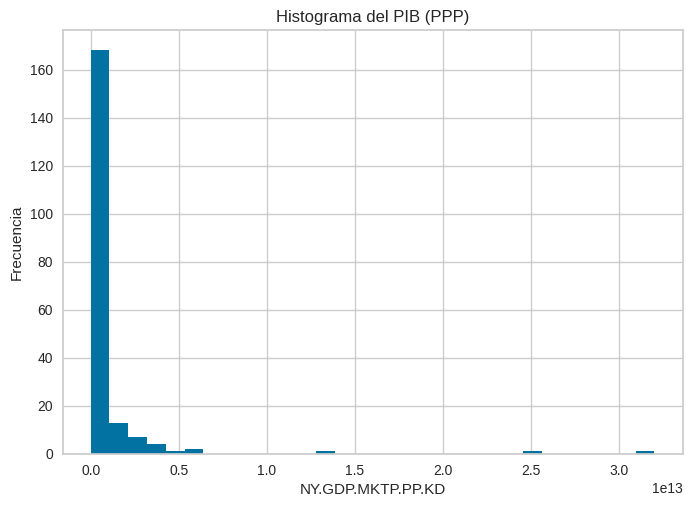

In [232]:
plt.figure()
plt.hist(df['NY.GDP.MKTP.PP.KD'], bins=30)
plt.xlabel('NY.GDP.MKTP.PP.KD')
plt.ylabel('Frecuencia')
plt.title('Histograma del PIB (PPP)')
plt.show()

In [233]:
import plotly.express as px
fig = px.choropleth(
    df,
    locations='country',
    color='NY.GDP.MKTP.PP.KD',
    hover_name='Country',
    projection='natural earth',
    title='PIB anual por paises',
    color_continuous_scale=px.colors.sequential.Blues  # Cambiar la escala de colores
)

# Ajustar el tamaño de la figura
fig.update_layout(
    width=1000,  # Ancho del gráfico
    height=600,  # Altura del gráfico
    title_font_size=24  # Tamaño de la fuente del título
)

# Mostrar el gráfico
fig.show()

# **Etapa 2: Reducción de Dimensionalidad con PCA**

El dataset contiene múltiples variables macroeconómicas, demográficas y sociales, por lo que se aplicará Análisis de Componentes Principales (`PCA`) con el objetivo de reducir la dimensionalidad y capturar los principales patrones subyacentes en los datos.

- Seleccionar únicamente variables numéricas y estandarizarlas previamente.
- Aplicar `PCA` y analizar la varianza explicada por cada componente.
- Elegir el número de componentes necesarias para explicar entre 70% y 90% de la varianza total, justificando brevemente dicha elección.
- Construir un nuevo DataFrame que contenga las componentes seleccionadas, el cual será utilizado como insumo para los modelos de clasificación posteriores.
- Documentar de forma clara los pasos realizados y las decisiones metodológicas adoptadas.


##Reducción de Dimensionalidad


*   *La reducción de dimensionalidad consiste en transformar un conjunto amplio de variables originales en un número menor de componentes que concentran la mayor parte de la información relevante. Este procedimiento permite simplificar la base de datos, reducir redundancias entre variables altamente correlacionadas y facilitar el análisis y la modelación, manteniendo al mismo tiempo la mayor proporción posible de la variabilidad original de los datos.*


Se usará PCA para agrupar

In [234]:
df.index = df['Country']

In [235]:
df = df.drop(columns = ['country','Country'])

In [236]:
df.head()

,NY.GDP.MKTP.PP.KD,SP.POP.GROW,SP.POP.TOTL,SP.POP.TOTL.FE.IN,SP.POP.TOTL.FE.ZS,SP.POP.TOTL.MA.IN,SP.POP.TOTL.MA.ZS,SP.URB.GROW,SP.URB.TOTL,SP.URB.TOTL.IN.ZS,...,NV.SRV.TOTL.CN,BM.KLT.DINV.CD.WD,BX.KLT.DINV.WD.GD.ZS,EN.GHG.CO2.IP.MT.CE.AR5,EG.CFT.ACCS.ZS,SP.DYN.LE00.FE.IN,SP.DYN.LE00.IN,SP.DYN.LE00.MA.IN,EG.CFT.ACCS.RU.ZS,EG.CFT.ACCS.UR.ZS
Country,,,,,,,,,,,,,,,,,,,,,
Zimbabwe,8.526678e+10,1.677096,16340822.0,8559888.0,52.383460,7780934.0,47.616540,3.180794,6420625.0,39.291937,...,3.348446e+10,3.050000e+07,1.684321,0.963600,30.700000,65.013,62.775,60.226,7.500000,77.000000
Zambia,7.612916e+10,2.794068,20723965.0,10467717.0,50.510204,10256248.0,49.489796,3.753005,9331708.0,45.028585,...,3.167001e+11,1.532150e+08,2.324653,1.290500,9.200000,68.673,66.349,63.936,2.300000,16.800000
West Bank and Gaza,2.769440e+10,2.393265,5165775.0,2598445.0,50.301172,2567330.0,49.698828,2.694855,4486873.0,86.857687,...,1.044720e+10,3.159065e+06,0.580098,-3.507426,69.968564,71.502,65.170,59.691,60.865185,78.950134
Viet Nam,1.359364e+12,0.671429,100352192.0,51201223.0,51.021529,49150969.0,48.978471,2.209665,38264181.0,38.129890,...,4.364896e+15,-1.550000e+09,4.264071,50.189800,98.700000,79.264,74.588,69.877,98.700000,99.400000
Vanuatu,1.030020e+09,2.324816,320409.0,158611.0,49.502667,161798.0,50.497333,2.374479,71340.0,22.265197,...,5.135585e+14,4.399200e+06,0.830619,0.001100,20.600000,73.927,71.477,69.445,9.000000,52.300000


In [237]:
y = df['NY.GDP.MKTP.PP.KD']
X = df.drop(columns='NY.GDP.MKTP.PP.KD')

In [238]:
#Escalar los datos
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_std = pd.DataFrame(X_std, columns=X.columns)

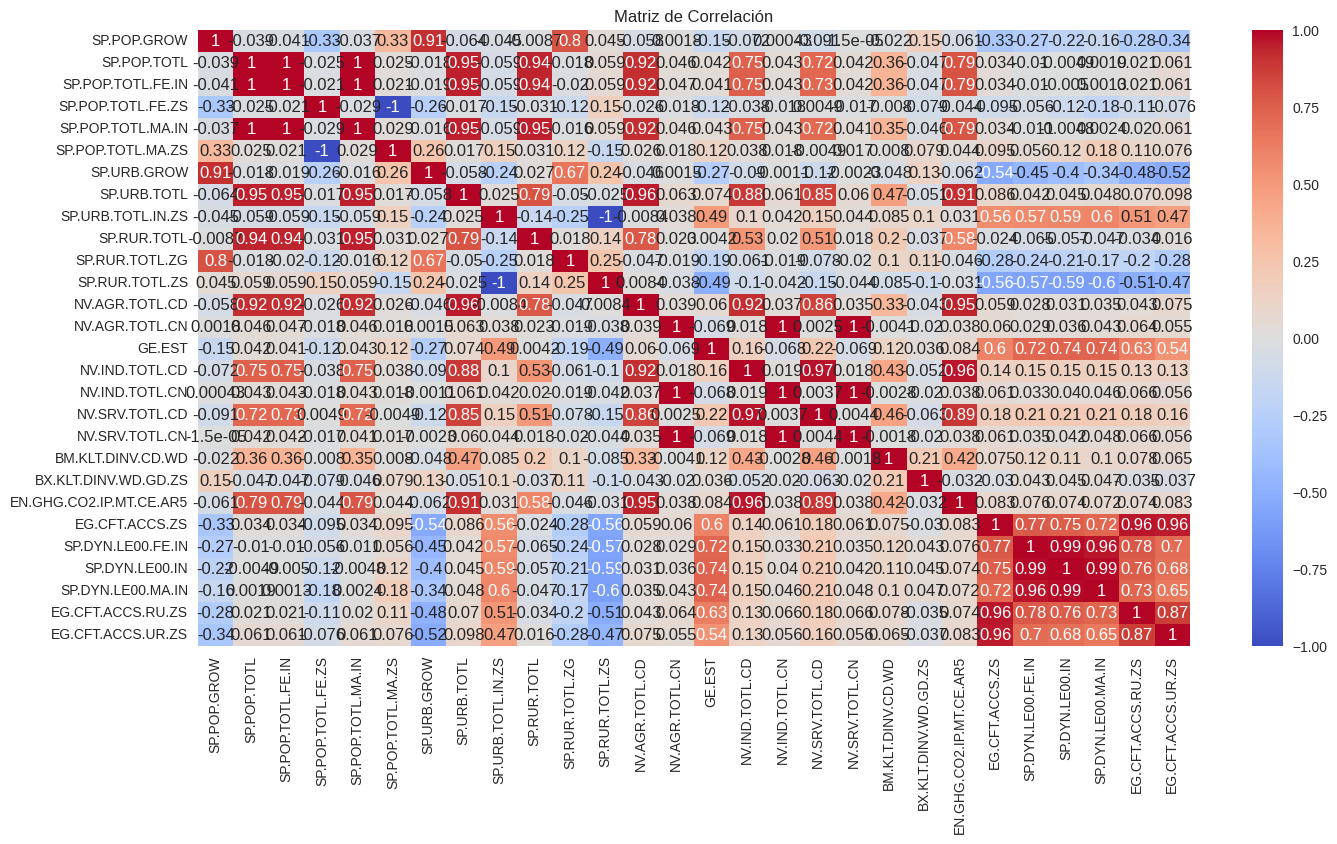

In [239]:
#Matriz de correlación
corr = X_std.corr()
plt.figure(figsize=(16, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Matriz de Correlación")
plt.show()

In [240]:
pca = PCA()
pca.fit(X_std)

pca.explained_variance_ratio_

array([2.95216603e-01, 2.46486913e-01, 1.07700757e-01, 1.02885606e-01,
       5.28214489e-02, 4.38793215e-02, 3.61944382e-02, 3.36784111e-02,
       2.68532783e-02, 2.13614628e-02, 1.33688819e-02, 8.11152424e-03,
       3.99576313e-03, 3.48393870e-03, 1.31893897e-03, 9.66644206e-04,
       7.95944551e-04, 4.23926521e-04, 2.55481926e-04, 1.68534082e-04,
       2.31255930e-05, 4.35408669e-06, 3.12360142e-06, 1.57848235e-06,
       9.99239672e-31, 5.82212092e-32, 1.48615480e-33, 1.48615480e-33])

In [241]:
# Seleccionar 5 componentes
pca_5 = PCA(n_components=5)
X_std_pca = pca_5.fit_transform(X_std)

X_std_pca = pd.DataFrame(X_std_pca, columns=['CP1', 'CP2', 'CP3', 'CP4', 'CP5'])
X_std_pca.head()

,CP1,CP2,CP3,CP4,CP5
0,-2.046253,-3.065171,-0.211515,-0.897442,0.345299
1,-2.168282,-3.310497,0.109859,0.654157,0.693553
2,-1.198110,-0.753850,0.118489,0.348651,0.245571
3,1.028192,-0.049061,1.125756,-1.040047,-0.274169
4,-1.672140,-2.408596,0.159428,0.401047,0.049707


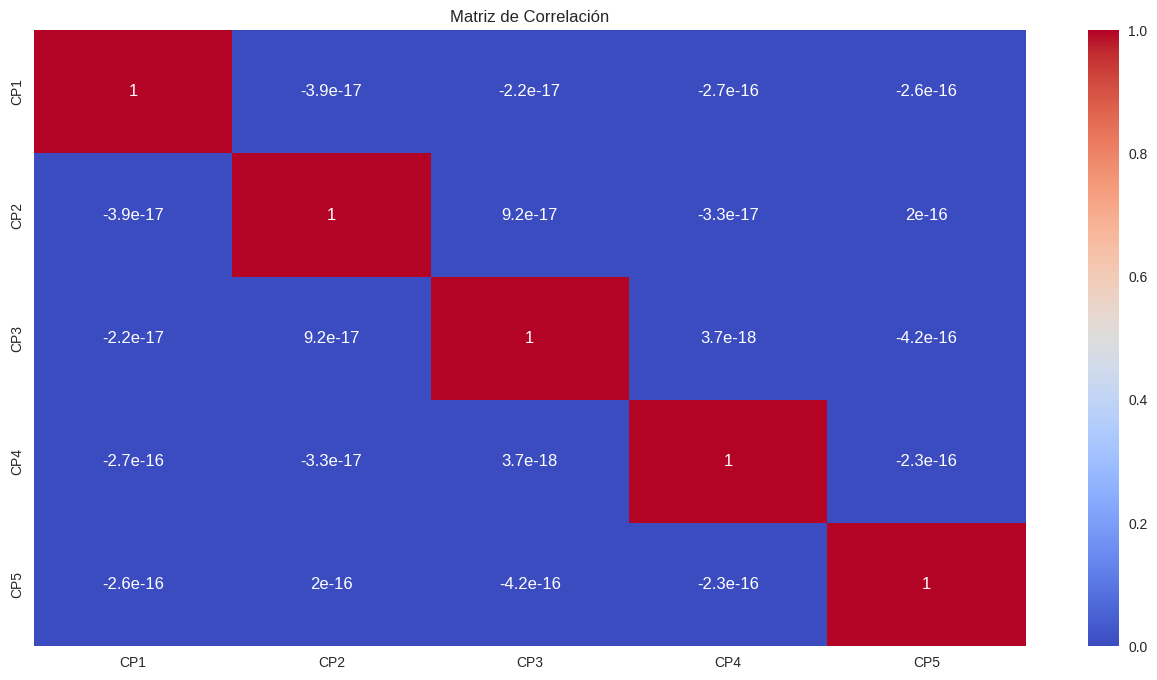

In [242]:
#Matriz de correlación
corr = X_std_pca.corr()
plt.figure(figsize=(16, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Matriz de Correlación")
plt.show()

In [243]:
X_std_pca

,CP1,CP2,CP3,CP4,CP5
0,-2.046253,-3.065171,-0.211515,-0.897442,0.345299
1,-2.168282,-3.310497,0.109859,0.654157,0.693553
2,-1.198110,-0.753850,0.118489,0.348651,0.245571
3,1.028192,-0.049061,1.125756,-1.040047,-0.274169
4,-1.672140,-2.408596,0.159428,0.401047,0.049707
...,...,...,...,...,...
193,-1.357610,-2.241644,0.189288,0.607146,0.358647
194,0.747669,3.396745,0.019026,1.360856,0.530980
195,0.568341,1.157625,0.049625,0.479671,-0.449531
196,0.268430,2.097453,-0.683227,-1.741088,-0.787648


#Etapa Final: Implementación y Comparación de Modelos de Clasificación

En esta etapa final del proyecto se procede a la implementación de modelos de clasificación, con el propósito de evaluar el efecto de la reducción de dimensionalidad sobre el desempeño predictivo y la estructura del problema. Las fases de proyecto son las siguientes:

En primer lugar, se construyen dos modelos de clasificación utilizando el conjunto de datos original, es decir, considerando la totalidad de las variables explicativas sin aplicar técnicas de reducción de dimensionalidad. Esta aproximación permite establecer una línea base (baseline) para el análisis comparativo posterior.
Posteriormente, se desarrollan los mismos modelos de clasificación empleando como variables de entrada las componentes principales obtenidas en la etapa de reducción de dimensionalidad mediante PCA. De esta forma, se evalúa si la representación reducida de los datos logra preservar información relevante para la tarea de clasificación.
Ambos enfoques se implementan bajo condiciones metodológicas comparables, manteniendo criterios consistentes de partición de datos y métricas de evaluación. El desempeño de los modelos se analiza mediante indicadores adecuados al problema de clasificación, permitiendo contrastar los resultados obtenidos con datos originales y con datos reducidos.

Finalmente, se realiza un análisis comparativo de los resultados, discutiendo las ventajas y limitaciones de cada enfoque, así como el impacto del uso de PCA en términos de desempeño, interpretabilidad y complejidad del modelo. Esta etapa cierra el proyecto integrando los aprendizajes obtenidos a lo largo de las fases previas y fundamentando las decisiones analíticas adoptadas.



## Modelo supervisado

### Supervisado Antiguo

In [244]:
df1 = df.copy()

In [245]:
df1['NY.GDP.MKTP.PP.KD'] = pd.qcut(df['NY.GDP.MKTP.PP.KD'], q=5, labels=['Low', 'Medium-Low', 'Medium', 'Medium-High', 'High'])

In [246]:
y = df1['NY.GDP.MKTP.PP.KD']
X = df1.drop(columns='NY.GDP.MKTP.PP.KD')

In [247]:
X_train, X_test, y_train, y_test =train_test_split(X, y,
                                                   test_size=0.2,
                                                   random_state=0)

In [248]:
# Estandarizar datos
std = StandardScaler()
X_train_std = std.fit_transform(X_train)
X_test_std = std.transform(X_test)

In [249]:
#@title Instanciar algoritmo de clasificación RFC
from sklearn.ensemble import RandomForestClassifier
rfc_clf = RandomForestClassifier(
    random_state=0,
    class_weight="balanced",
    n_estimators=100
)
# Aplicar modelo a datos de entrenamietno
classifier = rfc_clf.fit(X_train, y_train)


In [250]:
#@title Generar predicciones con datos test
y_pred_rfc = classifier.predict(X_test)

ValueError: The number of FixedLocator locations (5), usually from a call to set_ticks, does not match the number of labels (2).

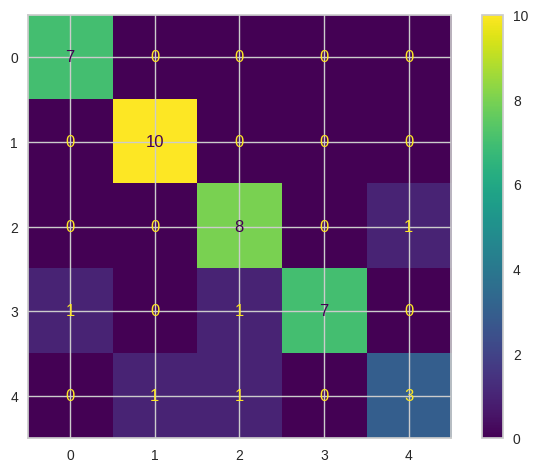

In [252]:
#@title Generar matriz de confusión
cm = confusion_matrix(y_true=y_test, y_pred=y_pred_rfc)
ConfusionMatrixDisplay(cm, display_labels=[0,1]).plot()
plt.show()
warnings.filterwarnings("ignore")

In [253]:
#@title Mostrar Reporte
SupervisadoAntiguo = classification_report(y_test, y_pred_rfc, output_dict=True)
SupervisadoAntiguo = pd.DataFrame(SupervisadoAntiguo).transpose()
SupervisadoAntiguo

,precision,recall,f1-score,support
High,0.875000,1.000000,0.933333,7.000
Low,0.909091,1.000000,0.952381,10.000
Medium,0.800000,0.888889,0.842105,9.000
Medium-High,1.000000,0.777778,0.875000,9.000
Medium-Low,0.750000,0.600000,0.666667,5.000
accuracy,0.875000,0.875000,0.875000,0.875
macro avg,0.866818,0.853333,0.853897,40.000
weighted avg,0.879148,0.875000,0.871111,40.000


### Supervisado PCA

In [254]:
y = df1['NY.GDP.MKTP.PP.KD']
X = X_std_pca

In [255]:
X_train, X_test, y_train, y_test =train_test_split(X, y,
                                                   test_size=0.2,
                                                   random_state=0)

In [256]:
# Estandarizar datos
std = StandardScaler()
X_train_std = std.fit_transform(X_train)
X_test_std = std.transform(X_test)

In [257]:
#@title Instanciar algoritmo de clasificación RFC
from sklearn.ensemble import RandomForestClassifier
rfc_clf = RandomForestClassifier(
    random_state=0,
    class_weight="balanced",
    n_estimators=100
)
# Aplicar modelo a datos de entrenamietno
classifier = rfc_clf.fit(X_train, y_train)


In [258]:
#@title Generar predicciones con datos test
y_pred_rfc = classifier.predict(X_test)

ValueError: The number of FixedLocator locations (5), usually from a call to set_ticks, does not match the number of labels (2).

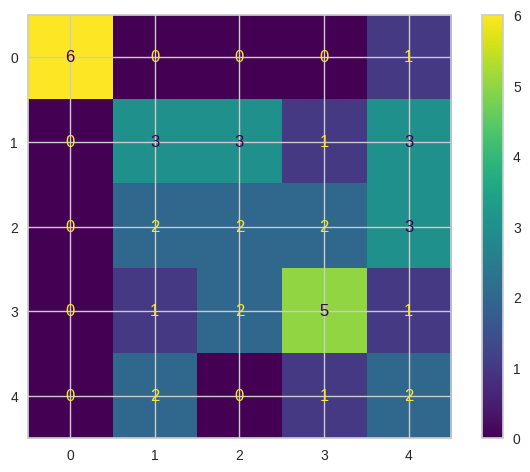

In [284]:
#@title Generar matriz de confusión
cm = confusion_matrix(y_true=y_test, y_pred=y_pred_rfc)
ConfusionMatrixDisplay(cm, display_labels=[0,1]).plot()
plt.show()
warnings.filterwarnings("ignore")

In [260]:
#@title Mostrar Reporte
SupervisadoPCA = classification_report(y_test, y_pred_rfc, output_dict=True)
SupervisadoPCA = pd.DataFrame(SupervisadoPCA).transpose()
SupervisadoPCA

,precision,recall,f1-score,support
High,1.000000,0.857143,0.923077,7.00
Low,0.375000,0.300000,0.333333,10.00
Medium,0.285714,0.222222,0.250000,9.00
Medium-High,0.555556,0.555556,0.555556,9.00
Medium-Low,0.200000,0.400000,0.266667,5.00
accuracy,0.450000,0.450000,0.450000,0.45
macro avg,0.483254,0.466984,0.465726,40.00
weighted avg,0.483036,0.450000,0.459455,40.00


## Comparación Sin PCA vs Con PCA

In [261]:
print("Reporte Supervisado Antiguo")
print(SupervisadoAntiguo)
print("-----------------------------------------------------")
print("Reporte Supervisado PCA")
print(SupervisadoPCA)

Reporte Supervisado Antiguo
              precision    recall  f1-score  support
High           0.875000  1.000000  0.933333    7.000
Low            0.909091  1.000000  0.952381   10.000
Medium         0.800000  0.888889  0.842105    9.000
Medium-High    1.000000  0.777778  0.875000    9.000
Medium-Low     0.750000  0.600000  0.666667    5.000
accuracy       0.875000  0.875000  0.875000    0.875
macro avg      0.866818  0.853333  0.853897   40.000
weighted avg   0.879148  0.875000  0.871111   40.000
-----------------------------------------------------
Reporte Supervisado PCA
              precision    recall  f1-score  support
High           1.000000  0.857143  0.923077     7.00
Low            0.375000  0.300000  0.333333    10.00
Medium         0.285714  0.222222  0.250000     9.00
Medium-High    0.555556  0.555556  0.555556     9.00
Medium-Low     0.200000  0.400000  0.266667     5.00
accuracy       0.450000  0.450000  0.450000     0.45
macro avg      0.483254  0.466984  0.465726   

Podemos notar que el reporte del modelo de clasificación supervisado con los datos sin agrupar (sin PCA), entregan mejores resultados, por lo que la reducción de la dimensionalidad no es óptima.

## No supervisado Antiguo

In [262]:
df_rf_imputer = df.copy()

In [263]:
#@title Escalar dataset
escalado = StandardScaler()
data_escalada = escalado.fit_transform(df_rf_imputer)
df_data_escalada = pd.DataFrame(data_escalada, index = df_rf_imputer.index, columns = df_rf_imputer.columns)
df_data_escalada.head()

,NY.GDP.MKTP.PP.KD,SP.POP.GROW,SP.POP.TOTL,SP.POP.TOTL.FE.IN,SP.POP.TOTL.FE.ZS,SP.POP.TOTL.MA.IN,SP.POP.TOTL.MA.ZS,SP.URB.GROW,SP.URB.TOTL,SP.URB.TOTL.IN.ZS,...,NV.SRV.TOTL.CN,BM.KLT.DINV.CD.WD,BX.KLT.DINV.WD.GD.ZS,EN.GHG.CO2.IP.MT.CE.AR5,EG.CFT.ACCS.ZS,SP.DYN.LE00.FE.IN,SP.DYN.LE00.IN,SP.DYN.LE00.MA.IN,EG.CFT.ACCS.RU.ZS,EG.CFT.ACCS.UR.ZS
Country,,,,,,,,,,,,,,,,,,,,,
Zimbabwe,-0.241385,0.333505,-0.159703,-0.156443,0.807138,-0.162788,-0.807138,0.796773,-0.205983,-1.010959,...,-9.338207e-02,-0.113470,-0.144497,-0.144001,-1.137803,-1.541781,-1.514099,-1.507735,-1.383937,-0.051179
Zambia,-0.244311,1.043945,-0.130112,-0.130072,0.179754,-0.130127,-0.179754,1.110932,-0.169589,-0.757854,...,-9.333057e-02,-0.110761,-0.094694,-0.140906,-1.754208,-1.033699,-1.008411,-0.984194,-1.515520,-1.994280
West Bank and Gaza,-0.259825,0.789018,-0.235149,-0.238846,0.109746,-0.231579,-0.109746,0.529980,-0.230158,1.087678,...,-9.338626e-02,-0.114073,-0.230380,-0.186330,-0.011973,-0.640976,-1.175229,-1.583232,-0.033563,0.011766
Viet Nam,0.166717,-0.306141,0.407480,0.432973,0.351005,0.383074,-0.351005,0.263598,0.192122,-1.062229,...,7.003466e-01,-0.148361,0.056149,0.322045,0.811757,0.436548,0.157329,-0.145823,0.923825,0.671835
Vanuatu,-0.268366,0.745482,-0.267862,-0.272571,-0.157687,-0.263319,0.157687,0.354085,-0.285361,-1.762191,...,-8.889440e-08,-0.114046,-0.210896,-0.153113,-1.427370,-0.304336,-0.282848,-0.206785,-1.345981,-0.848431


In [264]:
# Escalar dataset Min-Max
from sklearn.preprocessing import MinMaxScaler
escalado = MinMaxScaler()
data_min_max = escalado.fit_transform(df_rf_imputer)
data_min_max = pd.DataFrame(data_min_max, index = df_rf_imputer.index, columns = df_rf_imputer.columns)

In [265]:
#@title Instanciar modelos KMeans indicando k grupos
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer, silhouette_score
kmeans = KMeans(n_clusters = 3,
                random_state = 0,
                n_init='auto')

#Entrenar datos escalados
kmeans.fit(data_escalada)

KMeans(n_clusters=3, random_state=0)

In [266]:
#@title Obtener etiqueta de cluster
cluster = kmeans.labels_
cluster

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int32)

In [267]:
# Crear copia de dataframe
df_kmeans = df_rf_imputer.copy()
df_kmeans['cluster'] = cluster

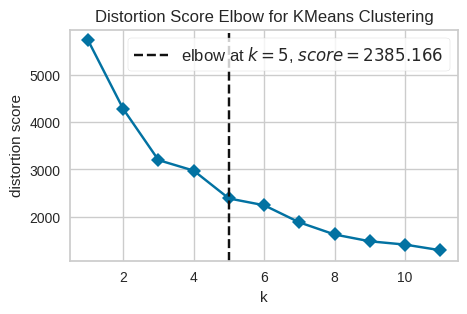

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [268]:
df_knn_op = df_data_escalada.copy()

# Instanciar modelo de agrupamiento
model = KMeans()

# Tamaño del gráfico
plt.figure(figsize=(5,3))

# Obtener métricas de acuerdo a k
visualizer = KElbowVisualizer(model, k=(1,12),
                              metric='distortion',
                              timings=False)

# Ajustar los datos a la visualizador
visualizer.fit(df_knn_op)
visualizer.show()


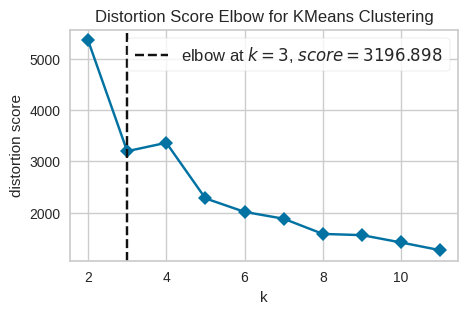

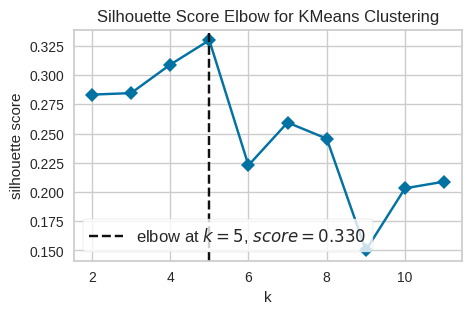

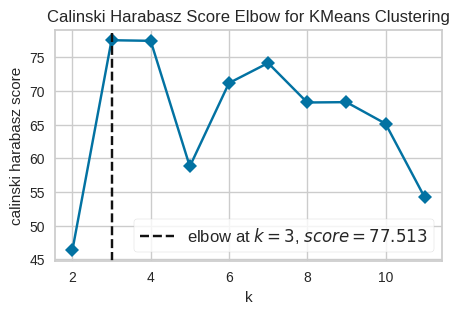

In [269]:
# Metricas de evalación
metricas = ['distortion','silhouette','calinski_harabasz']

# Selección k óptimo
for metrica in metricas:
  # Instanciar modelo de agrupamiento

  # Tamaño del gráfico
  plt.figure(figsize=(5, 3))
  # Obtener métricas de acuerdo a k
  visualizer = KElbowVisualizer(model, k=(2,12),
                                metric=metrica,
                                timings=False)

  # Ajustar los datos a la visualizador
  visualizer.fit(df_knn_op)
  visualizer.show();

In [270]:
X = data_escalada

param_grid = {
    'n_clusters': [2,3,4,5,6],
    'init': ['k-means++', 'random'],
    'n_init': [10,20,30,40]
}

kf = KFold(n_splits=10, shuffle=True, random_state=42)

def silhouette_scorer_func(estimator, X):
    labels = estimator.fit_predict(X)
    return silhouette_score(X, labels)

grid_search = GridSearchCV(
    estimator=KMeans(),
    param_grid=param_grid,
    scoring=make_scorer(silhouette_scorer_func),
    cv=kf,
    verbose=1
)

grid_search.fit(X)

best_params = grid_search.best_params_
best_kmeans = grid_search.best_estimator_

print("Mejores hiperparámetros:", best_params)
print("Silhouette Score asociado:", silhouette_score(X, best_kmeans.labels_))

Fitting 10 folds for each of 40 candidates, totalling 400 fits
Mejores hiperparámetros: {'init': 'k-means++', 'n_clusters': 2, 'n_init': 10}
Silhouette Score asociado: 0.8023033088469208


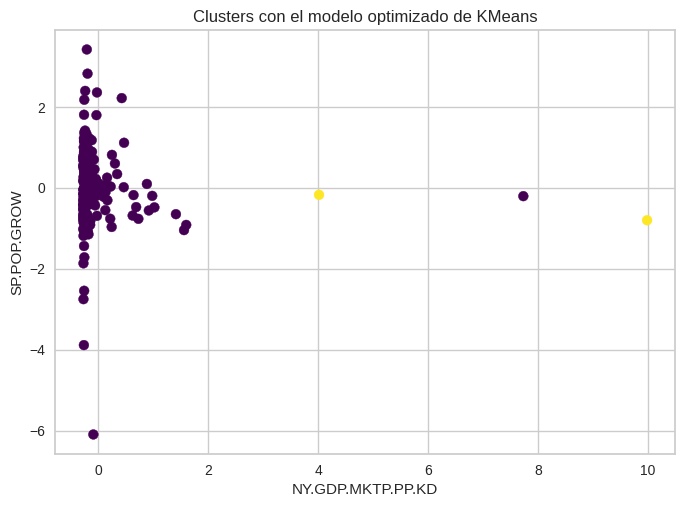

In [271]:
labels = best_kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50)
plt.title("Clusters con el modelo optimizado de KMeans")
plt.xlabel(df_data_escalada.columns[0])
plt.ylabel(df_data_escalada.columns[1])
plt.show()

In [272]:
df_data_escalada['cluster'] = labels
df_data_escalada

,NY.GDP.MKTP.PP.KD,SP.POP.GROW,SP.POP.TOTL,SP.POP.TOTL.FE.IN,SP.POP.TOTL.FE.ZS,SP.POP.TOTL.MA.IN,SP.POP.TOTL.MA.ZS,SP.URB.GROW,SP.URB.TOTL,SP.URB.TOTL.IN.ZS,...,BM.KLT.DINV.CD.WD,BX.KLT.DINV.WD.GD.ZS,EN.GHG.CO2.IP.MT.CE.AR5,EG.CFT.ACCS.ZS,SP.DYN.LE00.FE.IN,SP.DYN.LE00.IN,SP.DYN.LE00.MA.IN,EG.CFT.ACCS.RU.ZS,EG.CFT.ACCS.UR.ZS,cluster
Country,,,,,,,,,,,,,,,,,,,,,
Zimbabwe,-0.241385,0.333505,-0.159703,-0.156443,0.807138,-0.162788,-0.807138,0.796773,-0.205983,-1.010959,...,-0.113470,-0.144497,-0.144001,-1.137803,-1.541781,-1.514099,-1.507735,-1.383937,-0.051179,0
Zambia,-0.244311,1.043945,-0.130112,-0.130072,0.179754,-0.130127,-0.179754,1.110932,-0.169589,-0.757854,...,-0.110761,-0.094694,-0.140906,-1.754208,-1.033699,-1.008411,-0.984194,-1.515520,-1.994280,0
West Bank and Gaza,-0.259825,0.789018,-0.235149,-0.238846,0.109746,-0.231579,-0.109746,0.529980,-0.230158,1.087678,...,-0.114073,-0.230380,-0.186330,-0.011973,-0.640976,-1.175229,-1.583232,-0.033563,0.011766,0
Viet Nam,0.166717,-0.306141,0.407480,0.432973,0.351005,0.383074,-0.351005,0.263598,0.192122,-1.062229,...,-0.148361,0.056149,0.322045,0.811757,0.436548,0.157329,-0.145823,0.923825,0.671835,0
Vanuatu,-0.268366,0.745482,-0.267862,-0.272571,-0.157687,-0.263319,0.157687,0.354085,-0.285361,-1.762191,...,-0.114046,-0.210896,-0.153113,-1.427370,-0.304336,-0.282848,-0.206785,-1.345981,-0.848431,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Angola,-0.165247,1.226227,-0.021916,-0.018101,0.185007,-0.025554,-0.185007,1.374919,0.034676,0.337352,...,-0.113407,-0.429332,-0.136104,-0.578738,-1.245955,-1.253473,-1.243425,-1.361163,-0.115734,0
Andorra,-0.267022,0.178725,-0.269479,-0.274217,-0.374683,-0.264909,0.374683,-0.122302,-0.285355,1.174264,...,-0.109251,0.291185,-0.189061,0.849028,1.386496,1.494839,1.579040,0.956720,0.691201,0
Algeria,-0.044540,0.220213,0.041643,0.037836,-0.330016,0.045269,0.330016,0.281348,0.145061,0.552719,...,-0.110488,-0.237402,0.002032,0.840427,0.218878,0.394043,0.562298,0.933946,0.687974,0


### No supervisado PCA

In [273]:
df_rf_imputer

,NY.GDP.MKTP.PP.KD,SP.POP.GROW,SP.POP.TOTL,SP.POP.TOTL.FE.IN,SP.POP.TOTL.FE.ZS,SP.POP.TOTL.MA.IN,SP.POP.TOTL.MA.ZS,SP.URB.GROW,SP.URB.TOTL,SP.URB.TOTL.IN.ZS,...,NV.SRV.TOTL.CN,BM.KLT.DINV.CD.WD,BX.KLT.DINV.WD.GD.ZS,EN.GHG.CO2.IP.MT.CE.AR5,EG.CFT.ACCS.ZS,SP.DYN.LE00.FE.IN,SP.DYN.LE00.IN,SP.DYN.LE00.MA.IN,EG.CFT.ACCS.RU.ZS,EG.CFT.ACCS.UR.ZS
Country,,,,,,,,,,,,,,,,,,,,,
Zimbabwe,8.526678e+10,1.677096,16340822.0,8559888.0,52.383460,7780934.0,47.616540,3.180794,6420625.0,39.291937,...,3.348446e+10,3.050000e+07,1.684321,0.963600,30.700000,65.013,62.775,60.226,7.500000,77.000000
Zambia,7.612916e+10,2.794068,20723965.0,10467717.0,50.510204,10256248.0,49.489796,3.753005,9331708.0,45.028585,...,3.167001e+11,1.532150e+08,2.324653,1.290500,9.200000,68.673,66.349,63.936,2.300000,16.800000
West Bank and Gaza,2.769440e+10,2.393265,5165775.0,2598445.0,50.301172,2567330.0,49.698828,2.694855,4486873.0,86.857687,...,1.044720e+10,3.159065e+06,0.580098,-3.507426,69.968564,71.502,65.170,59.691,60.865185,78.950134
Viet Nam,1.359364e+12,0.671429,100352192.0,51201223.0,51.021529,49150969.0,48.978471,2.209665,38264181.0,38.129890,...,4.364896e+15,-1.550000e+09,4.264071,50.189800,98.700000,79.264,74.588,69.877,98.700000,99.400000
Vanuatu,1.030020e+09,2.324816,320409.0,158611.0,49.502667,161798.0,50.497333,2.374479,71340.0,22.265197,...,5.135585e+14,4.399200e+06,0.830619,0.001100,20.600000,73.927,71.477,69.445,9.000000,52.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Angola,3.229678e+11,3.080655,36749906.0,18568216.0,50.525887,18181690.0,49.474113,4.233833,25670362.0,69.851503,...,3.274279e+13,3.335616e+07,-1.977864,1.797700,50.200000,67.144,64.617,62.099,8.400000,75.000000
Andorra,5.225828e+09,1.433748,80856.0,39502.0,48.854754,41354.0,51.145246,1.506784,71816.0,88.820161,...,2.741340e+09,2.215940e+08,7.285975,-3.795838,100.000000,86.107,84.041,82.100,100.000000,100.000000
Algeria,6.998184e+11,1.498976,46164219.0,22614984.0,48.988123,23549235.0,51.011877,2.241995,34499817.0,74.732808,...,1.533987e+13,1.655830e+08,0.489819,16.388400,99.700000,77.696,76.261,74.895,99.100000,99.900000


In [274]:
#@title Escalar dataset
escalado = StandardScaler()
data_escalada = escalado.fit_transform(X_std_pca)
df_data_escalada = pd.DataFrame(data_escalada, index = X_std_pca.index, columns = X_std_pca.columns)
df_data_escalada.head()

,CP1,CP2,CP3,CP4,CP5
0,-0.711721,-1.166753,-0.121802,-0.528749,0.283930
1,-0.754165,-1.260136,0.063263,0.385412,0.570290
2,-0.416723,-0.286952,0.068232,0.205416,0.201926
3,0.357622,-0.018675,0.648270,-0.612769,-0.225442
4,-0.581598,-0.916828,0.091807,0.236287,0.040873


In [275]:
# Escalar dataset Min-Max
from sklearn.preprocessing import MinMaxScaler
escalado = MinMaxScaler()
data_min_max = escalado.fit_transform(df_rf_imputer)
data_min_max = pd.DataFrame(data_min_max, index = df_rf_imputer.index, columns = df_rf_imputer.columns)

In [276]:
#@title Instanciar modelos KMeans indicando k grupos
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer, silhouette_score
kmeans = KMeans(n_clusters = 3,
                random_state = 0,
                n_init='auto')

#Entrenar datos escalados
kmeans.fit(data_escalada)

KMeans(n_clusters=3, random_state=0)

In [277]:
#@title Obtener etiqueta de cluster
cluster = kmeans.labels_
cluster

array([1, 1, 1, 1, 1, 1, 0, 0, 0, 2, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 2, 1, 0, 1, 1, 0, 0, 2, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 2, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 2,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 2, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
      dtype=int32)

In [278]:
# Crear copia de dataframe
df_kmeans = df_rf_imputer.copy()
df_kmeans['cluster'] = cluster

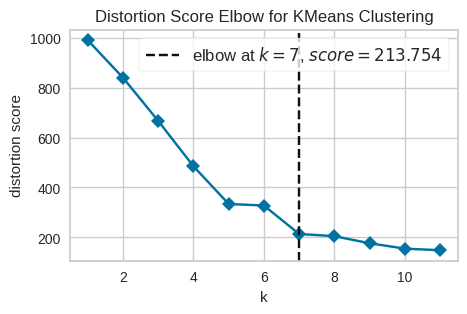

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [279]:
df_knn_op = df_data_escalada.copy()

# Instanciar modelo de agrupamiento
model = KMeans()

# Tamaño del gráfico
plt.figure(figsize=(5,3))

# Obtener métricas de acuerdo a k
visualizer = KElbowVisualizer(model, k=(1,12),
                              metric='distortion',
                              timings=False)

# Ajustar los datos a la visualizador
visualizer.fit(df_knn_op)
visualizer.show()


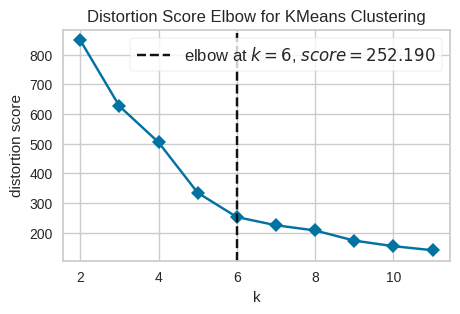

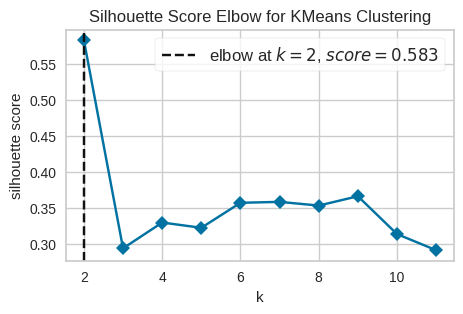

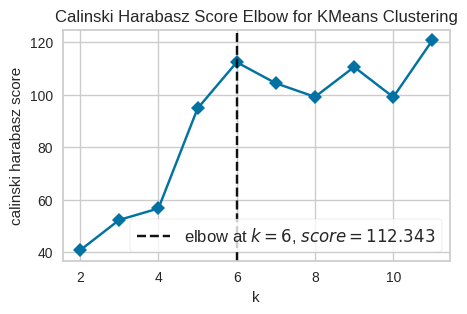

In [280]:
# Metricas de evalación
metricas = ['distortion','silhouette','calinski_harabasz']

# Selección k óptimo
for metrica in metricas:
  # Instanciar modelo de agrupamiento

  # Tamaño del gráfico
  plt.figure(figsize=(5, 3))
  # Obtener métricas de acuerdo a k
  visualizer = KElbowVisualizer(model, k=(2,12),
                                metric=metrica,
                                timings=False)

  # Ajustar los datos a la visualizador
  visualizer.fit(df_knn_op)
  visualizer.show();

In [281]:
X = data_escalada

param_grid = {
    'n_clusters': [2,3,4,5,6],
    'init': ['k-means++', 'random'],
    'n_init': [10,20,30,40]
}

kf = KFold(n_splits=10, shuffle=True, random_state=42)

def silhouette_scorer_func(estimator, X):
    labels = estimator.fit_predict(X)
    return silhouette_score(X, labels)

grid_search = GridSearchCV(
    estimator=KMeans(),
    param_grid=param_grid,
    scoring=make_scorer(silhouette_scorer_func),
    cv=kf,
    verbose=1
)

grid_search.fit(X)

best_params = grid_search.best_params_
best_kmeans = grid_search.best_estimator_

print("Mejores hiperparámetros:", best_params)
print("Silhouette Score asociado:", silhouette_score(X, best_kmeans.labels_))

Fitting 10 folds for each of 40 candidates, totalling 400 fits
Mejores hiperparámetros: {'init': 'k-means++', 'n_clusters': 2, 'n_init': 10}
Silhouette Score asociado: 0.8348603825044788


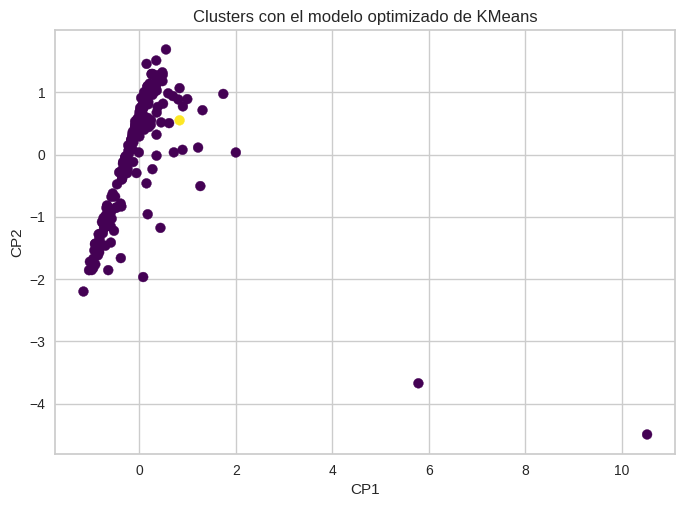

In [282]:
labels = best_kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50)
plt.title("Clusters con el modelo optimizado de KMeans")
plt.xlabel(df_data_escalada.columns[0])
plt.ylabel(df_data_escalada.columns[1])
plt.show()

In [283]:
df_data_escalada['cluster'] = labels
df_data_escalada

,CP1,CP2,CP3,CP4,CP5,cluster
0,-0.711721,-1.166753,-0.121802,-0.528749,0.283930,0
1,-0.754165,-1.260136,0.063263,0.385412,0.570290,0
2,-0.416723,-0.286952,0.068232,0.205416,0.201926,0
3,0.357622,-0.018675,0.648270,-0.612769,-0.225442,0
4,-0.581598,-0.916828,0.091807,0.236287,0.040873,0
...,...,...,...,...,...,...
193,-0.472200,-0.853278,0.109002,0.357715,0.294906,0
194,0.260052,1.292966,0.010956,0.801781,0.436610,0
195,0.197678,0.440648,0.028577,0.282610,-0.369637,0
196,0.093364,0.798392,-0.393438,-1.025804,-0.647661,0
